In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
import random
from sklearn.model_selection import GridSearchCV

# Đọc dữ liệu
final_data = pd.read_csv("final_data.csv")  # Final data cho tập huấn luyện
dataset_1 = pd.read_csv("dataset_1.csv")    # Dataset 1 cho tập kiểm tra

# Tách đặc trưng và nhãn cho final data (train)
X_train = final_data.drop(columns=["has_disease"])
y_train = final_data["has_disease"]

# Tách đặc trưng và nhãn cho dataset_1 (test)
X_test = dataset_1.drop(columns=["has_disease"])
y_test = dataset_1["has_disease"]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_data.info()
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Patient age quantile                                   950 non-null    int64  
 1   SARS-Cov-2 exam result                                 950 non-null    int64  
 2   Patient addmited to regular ward (1=yes, 0=no)         950 non-null    int64  
 3   Patient addmited to semi-intensive unit (1=yes, 0=no)  950 non-null    int64  
 4   Patient addmited to intensive care unit (1=yes, 0=no)  950 non-null    int64  
 5   Hematocrit                                             950 non-null    float64
 6   Hemoglobin                                             950 non-null    float64
 7   Platelets                                              950 non-null    float64
 8   Mean platelet volume                              

### Chạy với mô hình cơ bản

In [80]:
# Khởi tạo các mô hình cơ bản
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', C=1.0, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# Container để lưu kết quả
results = []

# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():    
    start_time = time.time()

    # Huấn luyện mô hình trên dữ liệu kết hợp
    model.fit(X_train_scaled, y_train)

    # Dự đoán trên dữ liệu real (test)
    predictions = model.predict(X_test_scaled)

    # Tính toán các chỉ số
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    elapsed_time = time.time() - start_time

    # Lưu kết quả cho mỗi mô hình
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Time (s)": elapsed_time
    })

# Chuyển kết quả thành DataFrame và in ra
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  Time (s)
0  Logistic Regression  0.551495   0.399061  0.923913  0.044251
1        Random Forest  0.945183   0.987097  0.831522  0.338906
2              XGBoost  0.948505   0.937143  0.891304  0.154536


C:\Users\dungp\AppData\Local\Temp\ipykernel_18308\331332640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0], palette="Blues_d")
C:\Users\dungp\AppData\Local\Temp\ipykernel_18308\331332640.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1], palette="Blues_d")
C:\Users\dungp\AppData\Local\Temp\ipykernel_18308\331332640.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2], palette="

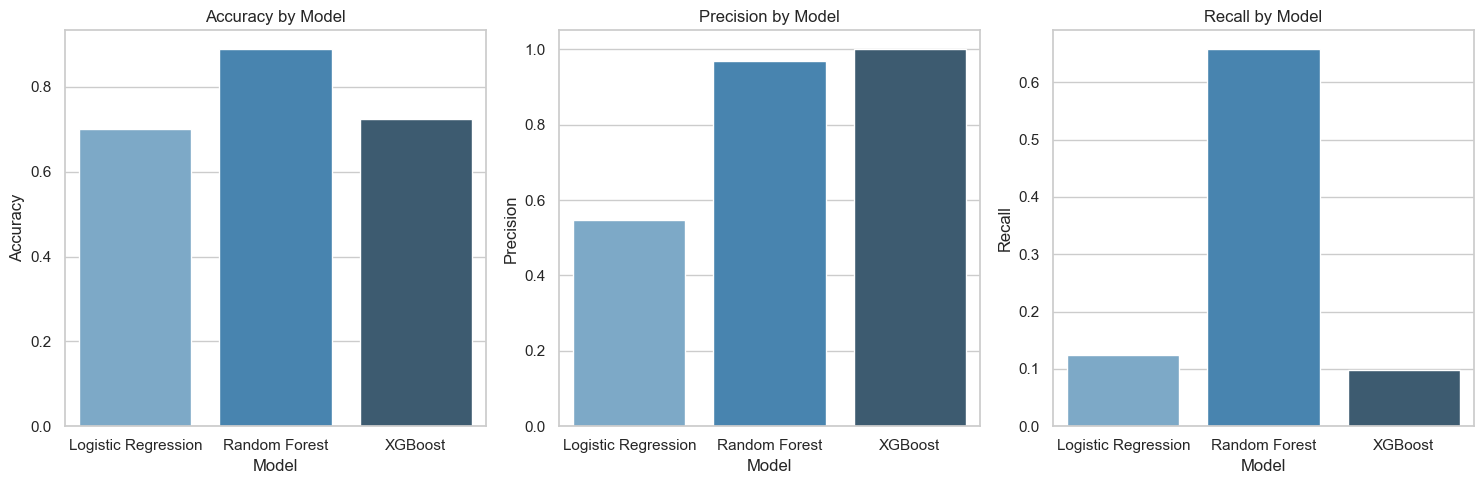

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for the plots
sns.set(style="whitegrid")

# Tạo biểu đồ cho Accuracy, Precision, Recall
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Chuyển lưới thành 1 hàng, 3 cột

# Biểu đồ Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0], palette="Blues_d")
axes[0].set_title('Accuracy by Model')

# Biểu đồ Precision
sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1], palette="Blues_d")
axes[1].set_title('Precision by Model')

# Biểu đồ Recall
sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2], palette="Blues_d")
axes[2].set_title('Recall by Model')

# Tinh chỉnh bố cục
plt.tight_layout()
plt.show()

### Chạy với CL

In [78]:
# Cài đặt Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=1000):
        self.max_size = max_size
        self.buffer = []

    def store(self, data, label, model=None):
        if model is not None:
            # Ưu tiên lưu các mẫu khó phân loại
            pred = model.predict([data])
            if pred != label:  # Chỉ lưu các mẫu phân loại sai
                self._add_to_buffer(data, label)
        else:
            self._add_to_buffer(data, label)

    def _add_to_buffer(self, data, label):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append((data, label))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Hàm tính Fisher Information cho mô hình
def compute_fisher_information(model, X_batch, y_batch):
    model.fit(X_batch, y_batch)  # Huấn luyện mô hình trên batch
    grad = np.array(model.coef_)  # Lấy gradient của trọng số
    fisher_information = np.abs(grad) ** 2  # Fisher Information Matrix ổn định hơn
    return fisher_information

# Hàm tính EWC Loss
def ewc_loss(model, fisher_information, previous_params, lambda_ewc=1.0):  # Tăng lambda
    current_params = np.array(model.coef_)
    return lambda_ewc * np.sum(fisher_information * (current_params - previous_params) ** 2)

# Khởi tạo các mô hình
logreg_model = LogisticRegression(solver='saga', max_iter=3000, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=100, learning_rate=0.01)

# GridSearch cho các mô hình
logreg_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', 'none'],
    'solver': ['saga', 'liblinear']
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

xgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7],
    'subsample': [0.8, 1.0]
}

# Khởi tạo GridSearchCV cho từng mô hình
logreg_grid_search = GridSearchCV(logreg_model, logreg_param_grid, cv=5, n_jobs=-1)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, n_jobs=-1)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, n_jobs=-1)

# Tạo DataFrame để lưu kết quả
logreg_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}
rf_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}
xgb_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}

# Khởi tạo Replay Buffer
batch_size = 64
num_batches = int(np.ceil(len(X_train_scaled) / batch_size))
replay_buffer = ReplayBuffer(max_size=500)

# Tổng thời gian cho từng mô hình
total_time_logreg = 0
total_time_rf = 0
total_time_xgb = 0

# Khởi tạo mô hình lần đầu tiên và tối ưu hóa bằng GridSearchCV
logreg_grid_search.fit(X_train_scaled[:batch_size], y_train[:batch_size])
rf_grid_search.fit(X_train_scaled[:batch_size], y_train[:batch_size])
xgb_grid_search.fit(X_train_scaled[:batch_size], y_train[:batch_size])

logreg_model = logreg_grid_search.best_estimator_
rf_model = rf_grid_search.best_estimator_
xgb_model = xgb_grid_search.best_estimator_

# Lưu trọng số ban đầu
previous_params_logreg = np.array(logreg_model.coef_)
previous_params_rf = np.array(rf_model.feature_importances_)
previous_params_xgb = xgb_model.get_booster().get_dump()[0]  # Lưu trọng số XGBoost

# Huấn luyện và đánh giá mô hình với Replay Buffer và EWC
for batch in range(num_batches):
    # Lấy batch dữ liệu
    X_batch = X_train_scaled[batch * batch_size:(batch + 1) * batch_size]
    y_batch = y_train[batch * batch_size:(batch + 1) * batch_size]

    # Kiểm tra nếu batch chỉ có một lớp
    unique_classes = np.unique(y_batch)
    if len(unique_classes) < 2:
        print(f"Skipping batch {batch + 1} due to insufficient classes.")
        continue

    # Training và đánh giá Logistic Regression
    start_time = time.time()
    logreg_model.fit(X_batch, y_batch)
    
    fisher_info_logreg = compute_fisher_information(logreg_model, X_batch, y_batch)
    ewc_loss_logreg = ewc_loss(logreg_model, fisher_info_logreg, previous_params_logreg)
    logreg_model.coef_ -= ewc_loss_logreg  # Cập nhật trọng số với EWC loss

    y_pred_logreg = logreg_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_logreg = end_time - start_time
    total_time_logreg += batch_time_logreg

    accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
    precision_logreg = precision_score(y_test, y_pred_logreg)
    recall_logreg = recall_score(y_test, y_pred_logreg)
    if batch == 0:
        prev_accuracy_logreg = accuracy_logreg
    forgetting_rate_logreg = prev_accuracy_logreg - accuracy_logreg
    prev_accuracy_logreg = accuracy_logreg

    logreg_results["Batch"].append(batch + 1)
    logreg_results["Accuracy"].append(accuracy_logreg)
    logreg_results["Precision"].append(precision_logreg)
    logreg_results["Recall"].append(recall_logreg)
    logreg_results["Forgetting Rate"].append(forgetting_rate_logreg)
    logreg_results["Time (s)"].append(batch_time_logreg)
    
    # Training và đánh giá Random Forest
    start_time = time.time()
    rf_model.fit(X_batch, y_batch)
    y_pred_rf = rf_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_rf = end_time - start_time
    total_time_rf += batch_time_rf

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf)
    recall_rf = recall_score(y_test, y_pred_rf)
    if batch == 0:
        prev_accuracy_rf = accuracy_rf
    forgetting_rate_rf = prev_accuracy_rf - accuracy_rf
    prev_accuracy_rf = accuracy_rf

    rf_results["Batch"].append(batch + 1)
    rf_results["Accuracy"].append(accuracy_rf)
    rf_results["Precision"].append(precision_rf)
    rf_results["Recall"].append(recall_rf)
    rf_results["Forgetting Rate"].append(forgetting_rate_rf)
    rf_results["Time (s)"].append(batch_time_rf)

    # Training và đánh giá XGBoost
    start_time = time.time()
    xgb_model.fit(X_batch, y_batch)
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_xgb = end_time - start_time
    total_time_xgb += batch_time_xgb

    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    precision_xgb = precision_score(y_test, y_pred_xgb)
    recall_xgb = recall_score(y_test, y_pred_xgb)
    if batch == 0:
        prev_accuracy_xgb = accuracy_xgb
    forgetting_rate_xgb = prev_accuracy_xgb - accuracy_xgb
    prev_accuracy_xgb = accuracy_xgb

    xgb_results["Batch"].append(batch + 1)
    xgb_results["Accuracy"].append(accuracy_xgb)
    xgb_results["Precision"].append(precision_xgb)
    xgb_results["Recall"].append(recall_xgb)
   

    xgb_results["Forgetting Rate"].append(forgetting_rate_xgb)
    xgb_results["Time (s)"].append(batch_time_xgb)

# Chuyển kết quả thành DataFrame cho từng mô hình
logreg_df = pd.DataFrame(logreg_results)
rf_df = pd.DataFrame(rf_results)
xgb_df = pd.DataFrame(xgb_results)

# Tính giá trị trung bình cho các mô hình
avg_accuracy_logreg = logreg_df["Accuracy"].mean()
avg_precision_logreg = logreg_df["Precision"].mean()
avg_recall_logreg = logreg_df["Recall"].mean()

avg_accuracy_rf = rf_df["Accuracy"].mean()
avg_precision_rf = rf_df["Precision"].mean()
avg_recall_rf = rf_df["Recall"].mean()

avg_accuracy_xgb = xgb_df["Accuracy"].mean()
avg_precision_xgb = xgb_df["Precision"].mean()
avg_recall_xgb = xgb_df["Recall"].mean()

# In kết quả cho các mô hình
print("Logistic Regression Results:")
print(logreg_df)
print(f"Total Time (Logistic Regression): {total_time_logreg:.2f} seconds")
print(f"Logistic Regression - Avg Accuracy: {avg_accuracy_logreg:.4f}, Precision: {avg_precision_logreg:.4f}, Recall: {avg_recall_logreg:.4f}")

print("\nRandom Forest Results:")
print(rf_df)
print(f"Total Time (Random Forest): {total_time_rf:.2f} seconds")
print(f"Random Forest - Avg Accuracy: {avg_accuracy_rf:.4f}, Precision: {avg_precision_rf:.4f}, Recall: {avg_recall_rf:.4f}")

print("\nXGBoost Results:")
print(xgb_df)
print(f"Total Time (XGBoost): {total_time_xgb:.2f} seconds")
print(f"XGBoost - Avg Accuracy: {avg_accuracy_xgb:.4f}, Precision: {avg_precision_xgb:.4f}, Recall: {avg_recall_xgb:.4f}")


c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py

Skipping batch 9 due to insufficient classes.
Skipping batch 10 due to insufficient classes.
Skipping batch 11 due to insufficient classes.
Skipping batch 12 due to insufficient classes.
Skipping batch 13 due to insufficient classes.
Logistic Regression Results:
   Batch  Accuracy  Precision    Recall  Forgetting Rate  Time (s)
0      1  0.642857   0.429864  0.516304         0.000000  0.031677
1      2  0.556478   0.369085  0.635870         0.086379  0.018346
2      3  0.566445   0.378549  0.652174        -0.009967  0.015625
3      4  0.612957   0.406130  0.576087        -0.046512  0.028658
4      5  0.569767   0.373737  0.603261         0.043189  0.015643
5      6  0.553156   0.363344  0.614130         0.016611  0.031262
6      7  0.546512   0.357827  0.608696         0.006645  0.016030
7      8  0.551495   0.363924  0.625000        -0.004983  0.047292
8     14  0.579734   0.374545  0.559783        -0.028239  0.031659
9     15  0.561462   0.366667  0.597826         0.018272  0.015644


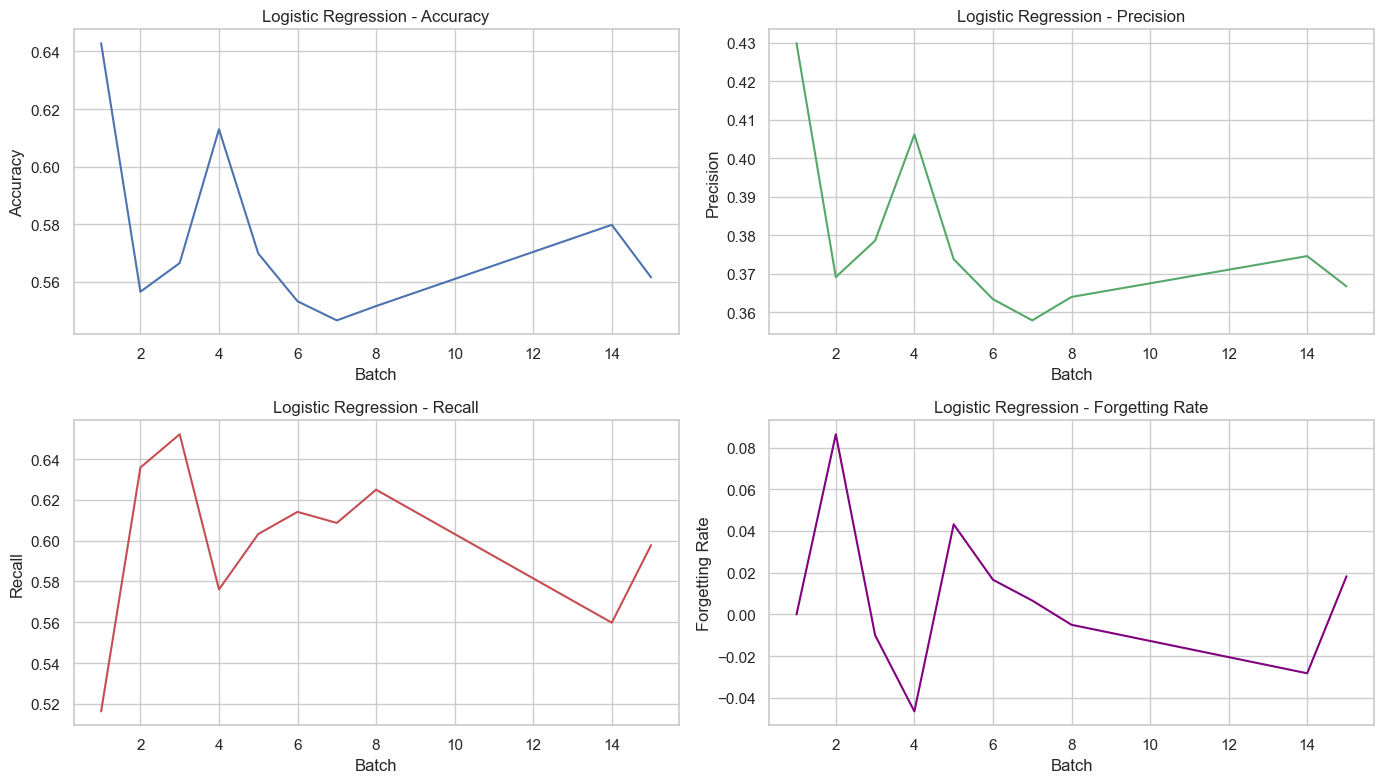

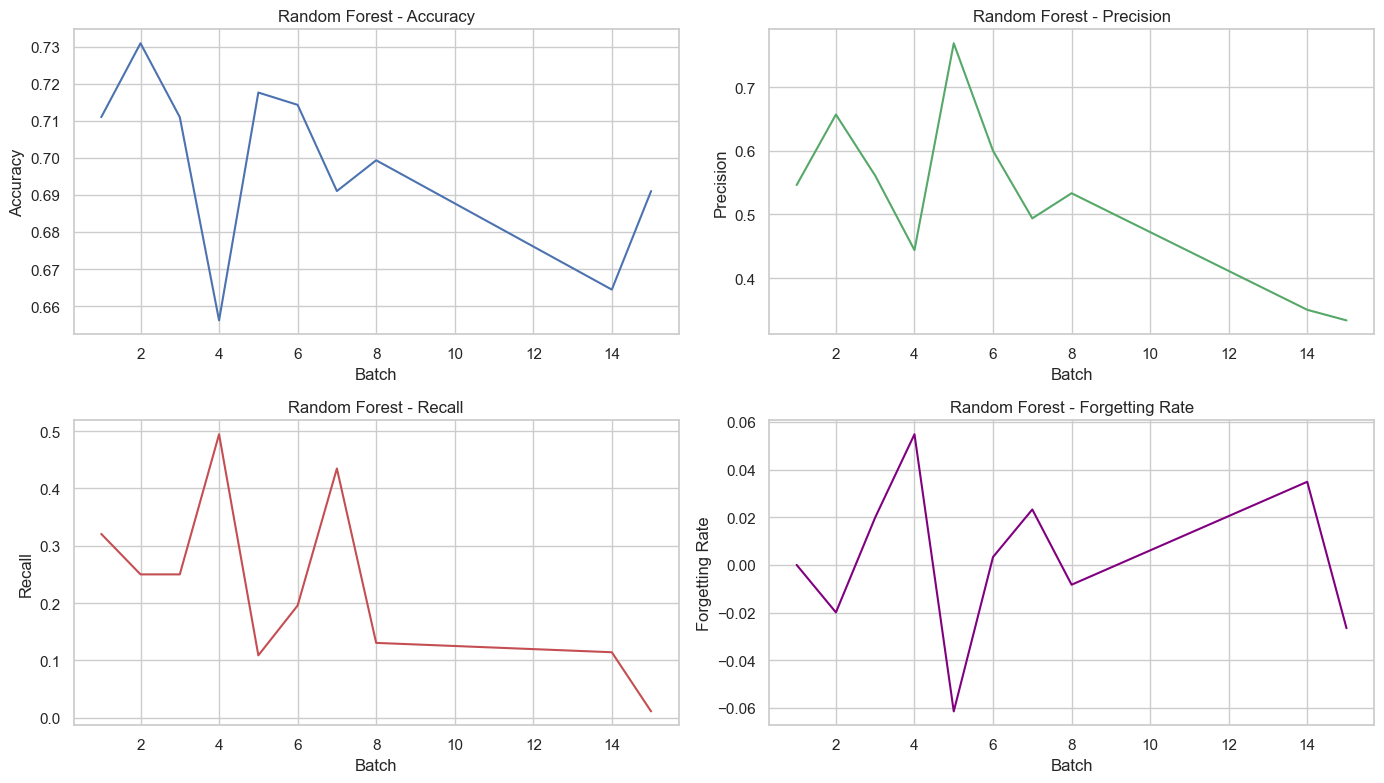

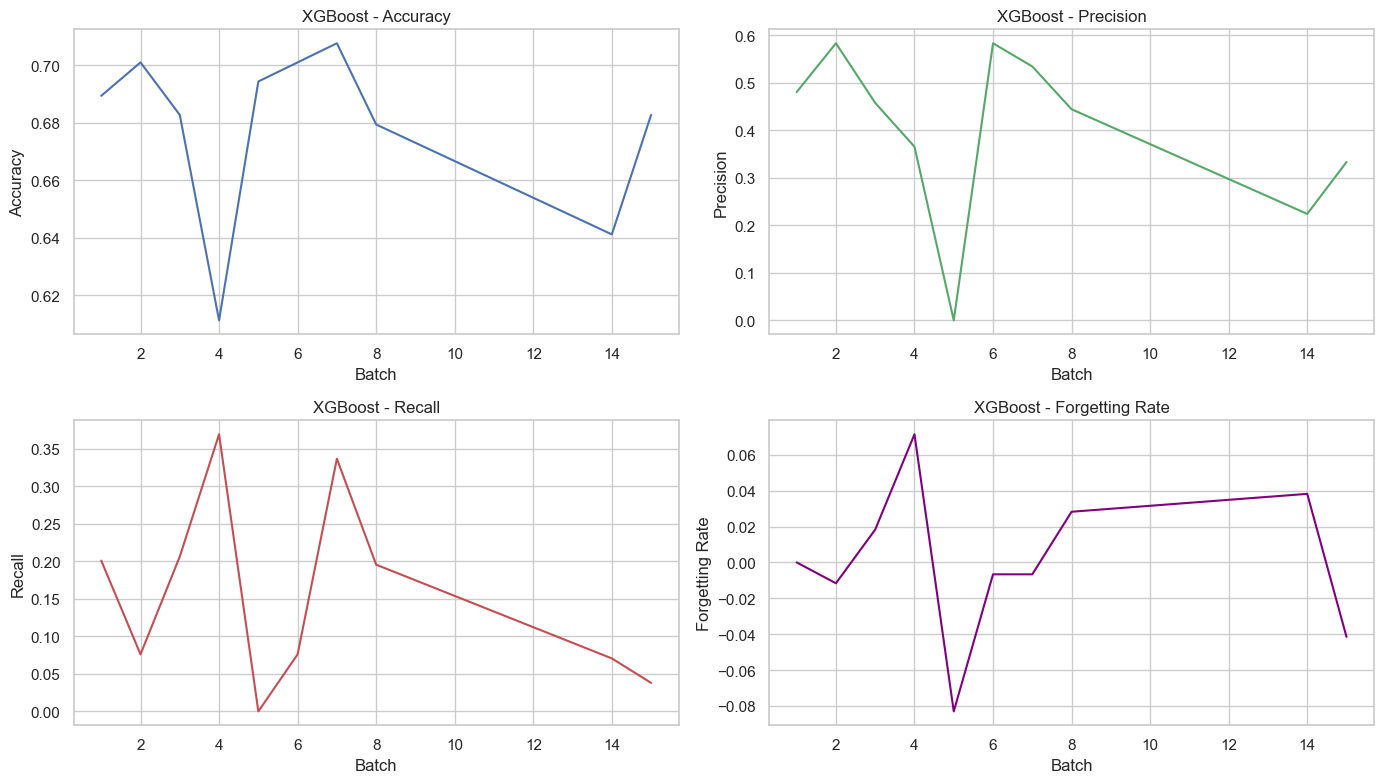

In [79]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho Logistic Regression
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(logreg_df['Batch'], logreg_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Logistic Regression - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(logreg_df['Batch'], logreg_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('Logistic Regression - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(logreg_df['Batch'], logreg_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('Logistic Regression - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(logreg_df['Batch'], logreg_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('Logistic Regression - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cho Random Forest
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(rf_df['Batch'], rf_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Random Forest - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(rf_df['Batch'], rf_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('Random Forest - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(rf_df['Batch'], rf_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('Random Forest - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(rf_df['Batch'], rf_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('Random Forest - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cho XGBoost
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(xgb_df['Batch'], xgb_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('XGBoost - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(xgb_df['Batch'], xgb_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('XGBoost - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(xgb_df['Batch'], xgb_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('XGBoost - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(xgb_df['Batch'], xgb_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('XGBoost - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()
